# Hyperparameter testing for ANN

We start by importing the necessary libraries and setting the random seed for reproducibility.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers.csv_logs import CSVLogger


In [2]:
seed = 78 # random seed, used for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


We now download the dataset and prepare it before training

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),               # random crop for augmentation
    transforms.RandomHorizontalFlip(),                  # horizontal flip for augmentation
    transforms.ToTensor(),                              # convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),      # normalize by mean and std per channel
                         (0.2470, 0.2435, 0.2616))      #These values come from "https://github.com/kuangliu/pytorch-cifar/issues/19" where the values for normalization were computed
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


In [4]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=False,
    download=True,
    transform=transform_test
)

With both datasets separated, we can now create dataloaders for each dataset

In [5]:
BATCH_SIZE = 64

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Finally, we will use these loaders and datasets to train our ANN model.

In [6]:
class LitANN(pl.LightningModule):
    def __init__(self, input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc4 = nn.Linear(hidden_size//4, num_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = x.view(x.size(0), -1)          # flatten for ANN
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)


In [7]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\torch\__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  return _C._get_float32_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:18<00:00, 39.05it/s, v_num=3]

Metric val_loss improved. New best score: 2.042


Epoch 1: 100%|██████████| 704/704 [00:27<00:00, 26.01it/s, v_num=3]

Metric val_loss improved by 0.138 >= min_delta = 0.005. New best score: 1.905


Epoch 2: 100%|██████████| 704/704 [00:27<00:00, 25.94it/s, v_num=3]

Metric val_loss improved by 0.094 >= min_delta = 0.005. New best score: 1.811


Epoch 3: 100%|██████████| 704/704 [00:29<00:00, 23.63it/s, v_num=3]

Metric val_loss improved by 0.059 >= min_delta = 0.005. New best score: 1.751


Epoch 4: 100%|██████████| 704/704 [00:30<00:00, 22.91it/s, v_num=3]

Metric val_loss improved by 0.051 >= min_delta = 0.005. New best score: 1.701


Epoch 5: 100%|██████████| 704/704 [00:30<00:00, 23.31it/s, v_num=3]

Metric val_loss improved by 0.041 >= min_delta = 0.005. New best score: 1.659


Epoch 7: 100%|██████████| 704/704 [00:29<00:00, 23.66it/s, v_num=3]

Metric val_loss improved by 0.053 >= min_delta = 0.005. New best score: 1.606


Epoch 9: 100%|██████████| 704/704 [00:31<00:00, 22.17it/s, v_num=3]

Metric val_loss improved by 0.053 >= min_delta = 0.005. New best score: 1.554
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 704/704 [00:31<00:00, 22.16it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 90.45it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.44749999046325684
        test_loss           1.5508058071136475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5508058071136475, 'test_acc': 0.44749999046325684}]

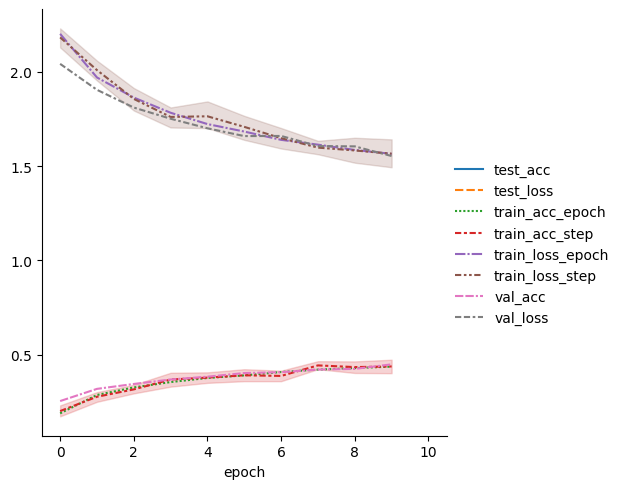

In [8]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

# Hyperparameters:
* Number of layers and units 
* Activation functions (ReLU, Sigmoid, Tanh, others)
* Optimizers (SGD, Adam, RMSprop) 
* Learning rate  - A
* Batch size - A
* Number of epochs  - A
* Weight initialization strategies (e.g., Xavier, He) 
* Dropout rate - A
* Batch Normalization (with vs without) 


Due to the need of a starting point, we started by using the parameters declared on the following link: https://www.chalisebibek.com.np/image-classification-with-pytorch-lightning-simple-ann. However, as we can see, the results are insatisfactory, which means that the hyperparameters need to be optimized. The current hyperparameters are not able to capture the complexity of the data. 

As stated before, due to the need of optimizing hyperparameters, we decided to increase the number of layers and continuing to funnel the number of neurons to try and prevent overfitting

In [9]:
trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory logs\ANN\version_3\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 704/704 [00:31<00:00, 22.18it/s, v_num=3]

Metric val_loss improved by 0.016 >= min_delta = 0.005. New best score: 1.538


Epoch 2: 100%|██████████| 704/704 [00:32<00:00, 21.49it/s, v_num=3]

Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 1.527


Epoch 3: 100%|██████████| 704/704 [00:34<00:00, 20.48it/s, v_num=3]

Metric val_loss improved by 0.013 >= min_delta = 0.005. New best score: 1.514


Epoch 5: 100%|██████████| 704/704 [00:36<00:00, 19.28it/s, v_num=3]

Metric val_loss improved by 0.026 >= min_delta = 0.005. New best score: 1.488


Epoch 7: 100%|██████████| 704/704 [00:34<00:00, 20.44it/s, v_num=3]

Metric val_loss improved by 0.017 >= min_delta = 0.005. New best score: 1.470


Epoch 8: 100%|██████████| 704/704 [00:34<00:00, 20.12it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.463


Epoch 9: 100%|██████████| 704/704 [00:34<00:00, 20.17it/s, v_num=3]

Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 1.458
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 704/704 [00:34<00:00, 20.15it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 99.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.47839999198913574
        test_loss            1.471976637840271
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.471976637840271, 'test_acc': 0.47839999198913574}]

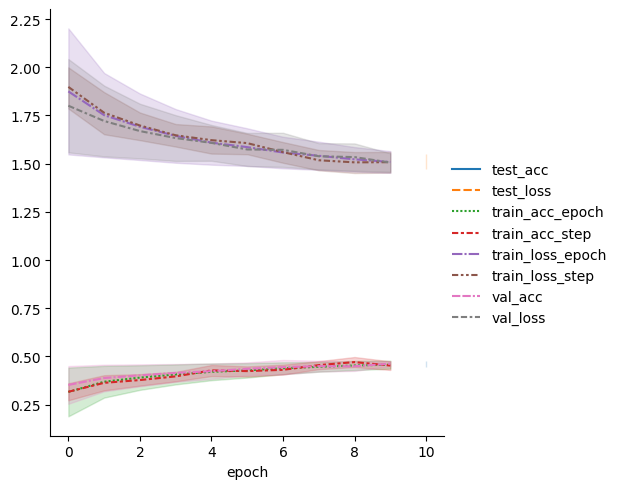

In [10]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

With the increase of the hidden layers, we can see that the accuracy and the loss both improved ever so slightly, without showing any signs of overfitting or underfitting. However, both metrics appear to be close to flatlining. So, in hopes of trying to discard the importance of the epochs, we tried to increase the number of epochs significantly and using early stopping with a min_delta of 0.005 to prevent overfitting. 


In [11]:
trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory logs\ANN\version_3\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:22<00:00, 31.75it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.451


Epoch 3: 100%|██████████| 704/704 [00:33<00:00, 21.13it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.445


Epoch 4: 100%|██████████| 704/704 [00:34<00:00, 20.20it/s, v_num=3]

Metric val_loss improved by 0.015 >= min_delta = 0.005. New best score: 1.430


Epoch 9: 100%|██████████| 704/704 [00:43<00:00, 16.09it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.423


Epoch 10: 100%|██████████| 704/704 [00:38<00:00, 18.38it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.416


Epoch 13: 100%|██████████| 704/704 [00:33<00:00, 21.32it/s, v_num=3]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.407


Epoch 14: 100%|██████████| 704/704 [00:33<00:00, 21.02it/s, v_num=3]

Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 1.395


Epoch 15: 100%|██████████| 704/704 [00:33<00:00, 20.79it/s, v_num=3]

Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 1.386


Epoch 20: 100%|██████████| 704/704 [00:28<00:00, 24.94it/s, v_num=3]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.386. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 704/704 [00:28<00:00, 24.92it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 89.14it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5133000016212463
        test_loss           1.3765015602111816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3765015602111816, 'test_acc': 0.5133000016212463}]

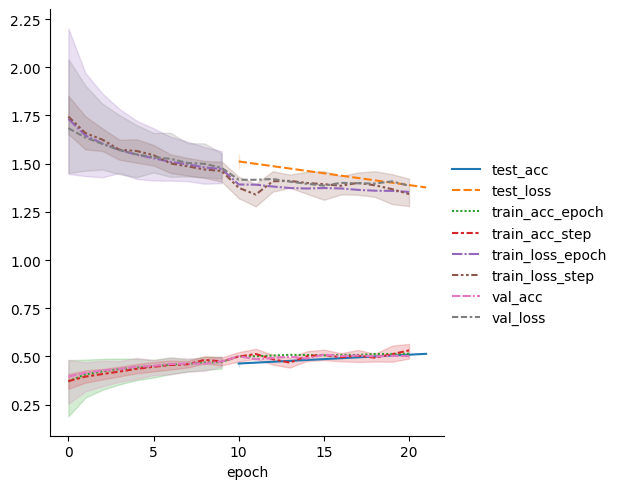

In [12]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

# Learning Rate

### LR = 1

In [15]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=1)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:23<00:00, 29.84it/s, v_num=5]

Metric val_loss improved. New best score: 2.329


Epoch 1: 100%|██████████| 704/704 [00:36<00:00, 19.55it/s, v_num=5]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 2.323


Epoch 6: 100%|██████████| 704/704 [00:34<00:00, 20.16it/s, v_num=5]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 2.317


Epoch 11: 100%|██████████| 704/704 [00:29<00:00, 23.97it/s, v_num=5]

Monitored metric val_loss did not improve in the last 5 records. Best score: 2.317. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 704/704 [00:29<00:00, 23.95it/s, v_num=5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 123.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.10000000149011612
        test_loss            2.348064661026001
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.348064661026001, 'test_acc': 0.10000000149011612}]

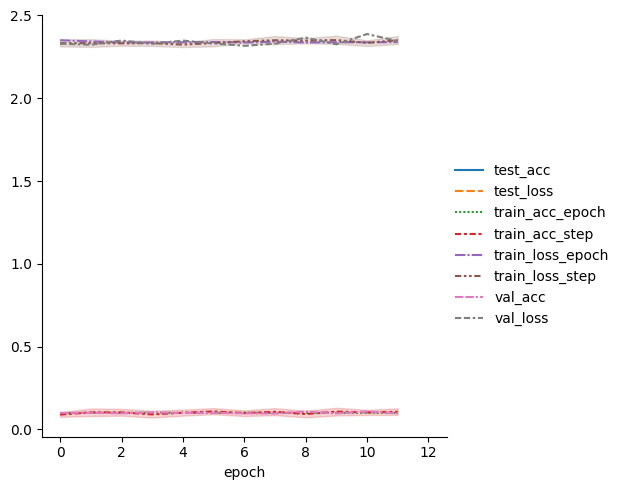

In [16]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

### LR = 0,5

In [17]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.5)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:26<00:00, 26.87it/s, v_num=6]

Metric val_loss improved. New best score: 2.308


Epoch 5: 100%|██████████| 704/704 [00:36<00:00, 19.18it/s, v_num=6]

Monitored metric val_loss did not improve in the last 5 records. Best score: 2.308. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 704/704 [00:36<00:00, 19.17it/s, v_num=6]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 120.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.10000000149011612
        test_loss           2.3186721801757812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.3186721801757812, 'test_acc': 0.10000000149011612}]

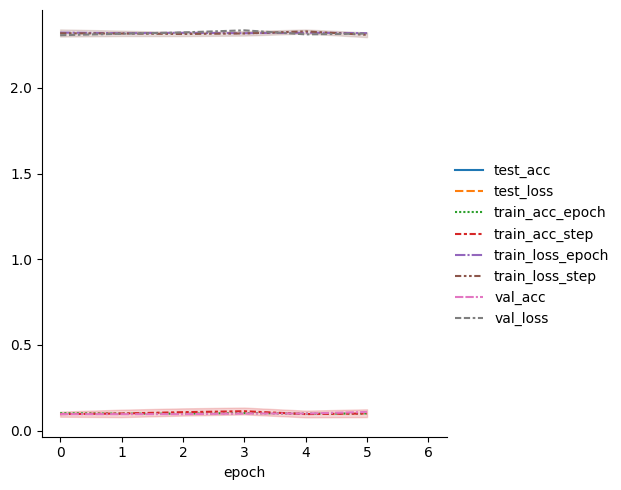

In [18]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

### LR = 0,1

In [19]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.1)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:20<00:00, 35.08it/s, v_num=7]

Metric val_loss improved. New best score: 2.274


Epoch 1: 100%|██████████| 704/704 [00:31<00:00, 22.16it/s, v_num=7]

Metric val_loss improved by 0.096 >= min_delta = 0.005. New best score: 2.178


Epoch 6: 100%|██████████| 704/704 [00:32<00:00, 21.95it/s, v_num=7]

Monitored metric val_loss did not improve in the last 5 records. Best score: 2.178. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 704/704 [00:32<00:00, 21.93it/s, v_num=7]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 104.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.14219999313354492
        test_loss           2.2299630641937256
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.2299630641937256, 'test_acc': 0.14219999313354492}]

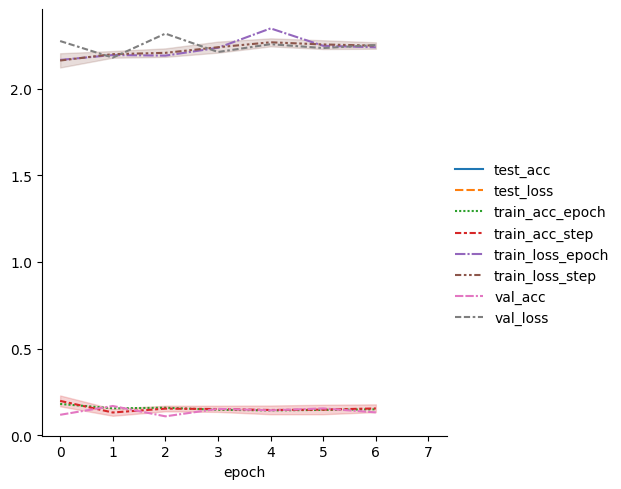

In [20]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

### LR = 0,05

In [21]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.05)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:23<00:00, 29.63it/s, v_num=8]

Metric val_loss improved. New best score: 1.930


Epoch 1: 100%|██████████| 704/704 [00:31<00:00, 22.09it/s, v_num=8]

Metric val_loss improved by 0.054 >= min_delta = 0.005. New best score: 1.876


Epoch 5: 100%|██████████| 704/704 [00:31<00:00, 22.44it/s, v_num=8]

Metric val_loss improved by 0.025 >= min_delta = 0.005. New best score: 1.851


Epoch 10: 100%|██████████| 704/704 [00:33<00:00, 20.93it/s, v_num=8]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.851. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 704/704 [00:33<00:00, 20.91it/s, v_num=8]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 91.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.24300000071525574
        test_loss           2.0295662879943848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.0295662879943848, 'test_acc': 0.24300000071525574}]

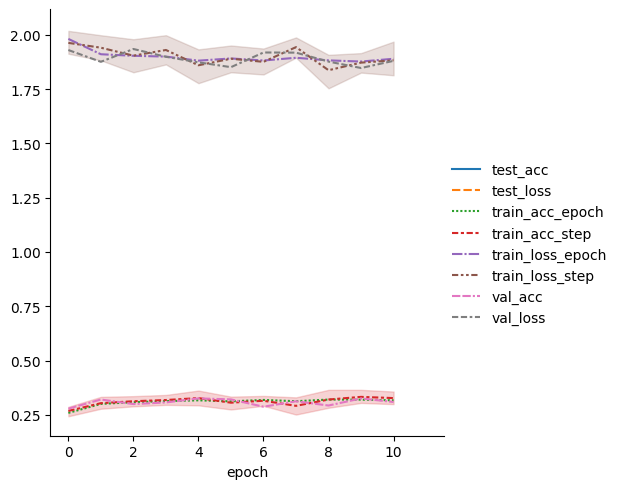

In [22]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

### LR = 0,01

In [23]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.01)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:24<00:00, 28.32it/s, v_num=9]

Metric val_loss improved. New best score: 1.783


Epoch 1: 100%|██████████| 704/704 [00:33<00:00, 20.72it/s, v_num=9]

Metric val_loss improved by 0.115 >= min_delta = 0.005. New best score: 1.668


Epoch 2: 100%|██████████| 704/704 [00:34<00:00, 20.47it/s, v_num=9]

Metric val_loss improved by 0.029 >= min_delta = 0.005. New best score: 1.639


Epoch 3: 100%|██████████| 704/704 [00:36<00:00, 19.41it/s, v_num=9]

Metric val_loss improved by 0.064 >= min_delta = 0.005. New best score: 1.575


Epoch 5: 100%|██████████| 704/704 [01:13<00:00,  9.64it/s, v_num=9]

Metric val_loss improved by 0.033 >= min_delta = 0.005. New best score: 1.542


Epoch 7: 100%|██████████| 704/704 [03:19<00:00,  3.53it/s, v_num=9] 

Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 1.532


Epoch 8: 100%|██████████| 704/704 [03:10<00:00,  3.70it/s, v_num=9]

Metric val_loss improved by 0.021 >= min_delta = 0.005. New best score: 1.511


Epoch 12: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, v_num=9] 

Metric val_loss improved by 0.030 >= min_delta = 0.005. New best score: 1.481


Epoch 16: 100%|██████████| 704/704 [03:51<00:00,  3.05it/s, v_num=9] 

Metric val_loss improved by 0.018 >= min_delta = 0.005. New best score: 1.463


Epoch 18: 100%|██████████| 704/704 [00:34<00:00, 20.44it/s, v_num=9]

Metric val_loss improved by 0.017 >= min_delta = 0.005. New best score: 1.446


Epoch 20: 100%|██████████| 704/704 [00:31<00:00, 22.64it/s, v_num=9]

Metric val_loss improved by 0.014 >= min_delta = 0.005. New best score: 1.432


Epoch 21: 100%|██████████| 704/704 [00:30<00:00, 23.45it/s, v_num=9]

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 1.425


Epoch 26: 100%|██████████| 704/704 [00:28<00:00, 25.04it/s, v_num=9]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.425. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 704/704 [00:28<00:00, 24.98it/s, v_num=9]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\afons\Desktop\FAP\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 122.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.49480000138282776
        test_loss           1.4229058027267456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.4229058027267456, 'test_acc': 0.49480000138282776}]

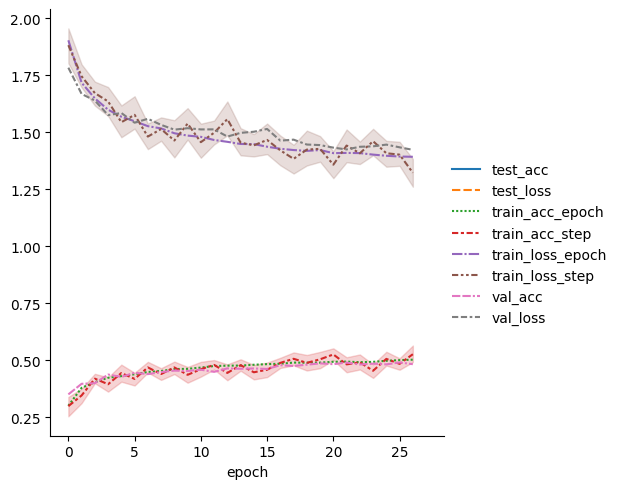

In [24]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

As we can see, the lower the value of the learning rate, the better accuracy and less loss we get